## Model Development - Smile Model

Importing required libraries

In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model
from keras_preprocessing.image import ImageDataGenerator, img_to_array
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
import imutils
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [29]:
#Reading the DataFrame
df = pd.read_csv("smile_data.csv")

In [30]:
#Sample Data
df.head()

,image_id,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000005.jpg,0
3,000006.jpg,0
4,000007.jpg,0


In [31]:
#Target Variable in the DataFrame
target_attr = list(df.columns[1:])

Generating the Dataset using the DataGenerator. The dataset size is too large and cannot be loaded into the memory at a time, so DataGenerators load the Data batch-wise.

Note: We are Training this model with 0% margin face-cropped Dataset which we created using the Data Processing Notebook("Data Processing.ipynb")

Note: Here we are using 75000 Images for Training purpose

In [32]:
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
train_generator=train_datagen.flow_from_dataframe(
    dataframe=df[:75000], directory="./Smile_Data/Train",
    x_col="image_id",
    y_col=target_attr,
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(100,100))

Found 75000 validated image filenames.


Similarly the TestGenerator to load the Validation Data to the model

In [34]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[75000:90000],
directory="./Smile_Data/Train",
x_col="image_id",
y_col=target_attr,
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(100,100))

Found 15000 validated image filenames.


In [9]:
#Checkpoint - To save the best model while training
checkpoint = ModelCheckpoint('./Smile_Data/Saved_models/model_75k_train_1-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

In [13]:
#Model Architecture

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = "RMSprop",loss="binary_crossentropy",metrics=["accuracy"])

In [14]:
#Model Training
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=valid_generator.n//valid_generator.batch_size
model.fit(train_generator,steps_per_epoch=step_size_train,validation_data=valid_generator,validation_steps=step_size_valid,
          epochs=15,callbacks=[checkpoint])

Epoch 1/15
2343/2343 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8502
Epoch 00001: val_loss improved from inf to 0.22412, saving model to ./Smile_Data/Saved_models\model_75k_train_1-001-0.334197-0.224122.h5
2343/2343 [==============================] - 2079s 887ms/step - loss: 0.3342 - accuracy: 0.8502 - val_loss: 0.2241 - val_accuracy: 0.9081
Epoch 2/15
2343/2343 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.8996
Epoch 00002: val_loss improved from 0.22412 to 0.20453, saving model to ./Smile_Data/Saved_models\model_75k_train_1-002-0.244889-0.204533.h5
2343/2343 [==============================] - 1952s 833ms/step - loss: 0.2449 - accuracy: 0.8996 - val_loss: 0.2045 - val_accuracy: 0.9121
Epoch 3/15
2343/2343 [==============================] - ETA: 0s - loss: 0.2307 - accuracy: 0.9057
Epoch 00003: val_loss did not improve from 0.20453
2343/2343 [==============================] - 1998s 853ms/step - loss: 0.2307 - accuracy: 0.9057 - val

KeyboardInterrupt: 

In [7]:
#Loading the best model
model = tf.keras.models.load_model("./Smile_Data/Saved_models/model_75k_train_1-008-0.219267-0.186961.h5")

In [ ]:
#Saving the weights of the best model
model.save_weights("./weights_smile.h5")

### Testing of the Model

Helper function which takes the path of an Image and predicts whether the person is Smiling or Not.

In [36]:
def predict_smile(source):
    image = cv2.imread(source,1)
    image = imutils.resize(image, width=200)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.2,10,minSize=(50,50))
    if len(faces)==0:
            print("NotFound")
    else:
        max_area = 0
        for i in range(len(faces)):
            x, y, w, h = faces[i]
            if (w*h > max_area):
                max_area = w*h
                idx = i
        if(max_area<=400):
            print("NotFound")
    X, Y, w, h = faces[idx]
    cropped_image = image[Y:Y+h, X:X+w]
    cropped_image= cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_image)
    plt.show()
    cropped_image = cv2.resize(cropped_image, (100, 100))
    array = img_to_array(cropped_image)
    array = array/255.0
    arr = np.reshape(array,(100,100,3))
    out = model.predict(np.array([arr]))[0][0]
    print("probability_smile:",out)
    if(out>0.5):
        print("Smiling")
    else:
        print("Not Smiling")
    

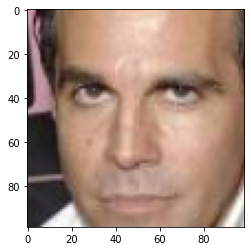

probability_smile: 0.06321263
Not Smiling


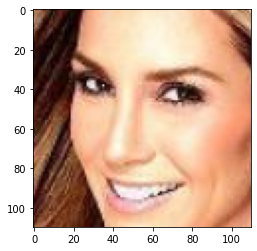

probability_smile: 0.9997325
Smiling


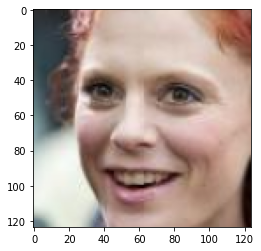

probability_smile: 0.99878776
Smiling


In [37]:
predict_smile("./img_align_celeba//img_align_celeba//000008.jpg")
predict_smile("./img_align_celeba//img_align_celeba//000001.jpg")
predict_smile("./img_align_celeba//img_align_celeba//000002.jpg")